#Facial Emotion Detection with landmarks


In [ ]:
#mount drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Install all requirments

In [ ]:
!python -m pip install -U -r requirements.txt

     |████████████████████████████████| 1.1 MB 10.2 MB/s 
     |████████████████████████████████| 15.7 MB 50.4 MB/s 
     |████████████████████████████████| 48 kB 6.6 MB/s 
     |████████████████████████████████| 11.2 MB 55.3 MB/s 
     |████████████████████████████████| 13.3 MB 59.5 MB/s 
     |████████████████████████████████| 60.4 MB 1.3 MB/s 
     |████████████████████████████████| 22.7 MB 100.5 MB/s 
     |████████████████████████████████| 3.2 MB 55.8 MB/s 
     |████████████████████████████████| 895 kB 60.8 MB/s 
  Created wheel for ReliefF: filename=ReliefF-0.1.2-py3-none-any.whl size=6319 sha256=b7e7b59010730a17b8c64cf5884419ff593adec06f857772077acedd249b0520
  Stored in directory: /root/.cache/pip/wheels/18/8a/4a/3aada56cb869df4c1b1ed6af509c941a25985d1d1258a2e78c
  Created wheel for dlib: filename=dlib-19.23.0-cp37-cp37m-linux_x86_64.whl size=4348472 sha256=21ea40c9c3453d259be878f58fc1f757d21f081b224d33b49fb092c8f4e41db6
  Stored in directory: /root/.cache/pip/wheels/9a/f6/7a/

In [ ]:
!python -m pip uninstall matplotlib
!pip install matplotlib==3.1.3

Found existing installation: matplotlib 3.5.1
Uninstalling matplotlib-3.5.1:
  Would remove:
    /usr/local/lib/python3.7/dist-packages/matplotlib-3.5.1-py3.7-nspkg.pth
    /usr/local/lib/python3.7/dist-packages/matplotlib-3.5.1.dist-info/*
    /usr/local/lib/python3.7/dist-packages/matplotlib/*
    /usr/local/lib/python3.7/dist-packages/mpl_toolkits/axes_grid/*
    /usr/local/lib/python3.7/dist-packages/mpl_toolkits/axes_grid1/*
    /usr/local/lib/python3.7/dist-packages/mpl_toolkits/axisartist/*
    /usr/local/lib/python3.7/dist-packages/mpl_toolkits/mplot3d/*
    /usr/local/lib/python3.7/dist-packages/mpl_toolkits/tests/*
    /usr/local/lib/python3.7/dist-packages/pylab.py
Proceed (y/n)? y\
Your response ('y\\') was not one of the expected responses: y, n
Proceed (y/n)? y
  Successfully uninstalled matplotlib-3.5.1
     |████████████████████████████████| 13.1 MB 5.3 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This 

#Import the necessary libraries

In [ ]:
import cv2, sys, os, joblib
from glob import glob
from tqdm.notebook import trange, tqdm
import numpy as np

# !pip instal dlib # how to from https://github.com/ageitgey/face_recognition/issues/175
# !pip install face_recognition
import dlib # Landmarks algorithme
import math
from skimage import feature 
from skimage.feature import hog
import random
import pandas as pd

from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB

from sklearn.pipeline import make_pipeline, Pipeline

from sklearn.model_selection import KFold, ShuffleSplit, train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report, f1_score

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from ReliefF import ReliefF 

import matplotlib.pyplot as plt
import matplotlib.image as mpimg 
%matplotlib inline
import seaborn as sns 
home = '/content/drive/MyDrive/Final_Dataset/'


# Detect faces and draw landmarks with DLIP

In [ ]:

detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor(home+"shape_predictor_68_face_landmarks.dat")


def draw_face_landmarks(img_path, flag = False):
    img = cv2.imread(img_path)
    image = cv2.imread(img_path, 0)
    detections = detector(image, 1)
    best_face = 0
    xm, ym, wm, hm = 0, 0, 0, 0
    if len(detections) > 1:
        
        max_surface = 0
        
        for i, face in enumerate(detections):
            # Finding points for rectangle to draw on face
            xi, yi, wi, hi = face.left(), face.top(), face.width(), face.height()
            if wi*hi > max_surface:
                xm, ym, wm, hm = xi, yi, wi, hi
                max_surface = wi*hi
                best_face = i
    elif len(detections) < 1:
        return None

    for f, face in enumerate(detections):
        # Draw Facial Landmarks with the predictor class
        shape = predictor(image, face)
        xlist = []
        ylist = []
        for i in range(68):  # Store X and Y coordinates in two lists
            xlist.append(int(shape.part(i).x))
            ylist.append(int(shape.part(i).y))

        def draw_line(x, y, g=True):
            if g:
                cv2.line(img, (xlist[x], ylist[x]),
                         (xlist[y], ylist[y]), (0, 255, 0), 1)
            else:
                cv2.line(img, (xlist[x], ylist[x]),
                         (xlist[y], ylist[y]), (155, 0, 247), 1)
        g = False
        if f == best_face:
            g = True

        for i in range(16):
            draw_line(i, i+1, g)
        for i in range(17, 21):
            draw_line(i, i+1, g)
        for i in range(22, 26):
            draw_line(i, i+1, g)
        for i in range(36, 41):
            draw_line(i, i+1, g)
        draw_line(36, 41, g)
        for i in range(42, 47):
            draw_line(i, i+1, g)
        draw_line(42, 47, g)

        for i in range(27, 35):
            draw_line(i, i+1, g)
        draw_line(30, 35, g)

        for i in range(48, 59):
            draw_line(i, i+1, g)
        draw_line(48, 59, g)
        for i in range(60, 67):
            draw_line(i, i+1, g)
        draw_line(60, 67, g)

    # Drawing simple rectangle around found faces
    if flag and xm is not None:
        cv2.rectangle(img, (xm, ym), (xm + wm, ym + hm), (0, 0, 255), 2)
#     cv2.imwrite(home+'4_2.png', img)
    return img

In [ ]:
def get_face_landmarks(img_path, flag=False):
    """
   Another way to detect the face.
    """
    image = cv2.imread(img_path, 0)
    try:
        detections = detector(image, 1)
    except:
        return None
    
    # On s'interisse au visage de grande dimension qui est le plus proche dans l'image
    best_face_id = 0
    if len(detections) > 1:
        max_surface = 0
        xm, ym, wm, hm = 0, 0, 0, 0
        for i, face in enumerate(detections):
            # Finding points for rectangle to draw on face
            xi, yi, wi, hi = face.left(), face.top(), face.width(), face.height()
            if wi*hi > max_surface:
                xm, ym, wm, hm = xi, yi, wi, hi
                max_surface = wi*hi
                best_face_id = i
    elif len(detections) < 1:
        return None
    
    # Draw Facial Landmarks with the predictor class
    shape = predictor(image, detections[best_face_id])
    xlist = []
    ylist = []
    for i in range(68):  # Store X and Y coordinates in two lists
        xlist.append(int(shape.part(i).x))
        ylist.append(int(shape.part(i).y))
    # Estimation de visage
    xmin, xmax, ymin, ymax = np.min(xlist), np.max(
        xlist), np.min(ylist), np.max(ylist)
    w, h = xmax-xmin, ymax-ymin
    if ymin <= h/3:
        ymin = 0
    else:
        ymin -= int(h/3)

    if xmin <= w/5:
        xmin = 0
    else:
        xmin -= int(w/5)

    wight = image.shape[1]
    if xmax >= wight-w/5:
        xmax = wight
    else:
        xmax += int(w/5)
    
    if flag:
        face_seg = cv2.imread(img_path)[ymin:ymax, xmin:xmax]
    else:
        face_seg = image[ymin:ymax, xmin:xmax]
        face_seg = cv2.resize(face_seg, (96, 96), interpolation = cv2.INTER_AREA)
    return face_seg

In [ ]:
def pltC(img):
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

def plot_img(list_img):
    fig, ax = plt.subplots(1, len(list_img), figsize=(22, 8),
                       subplot_kw=dict(xticks=[], yticks=[]))
    
    for i, (img, title) in enumerate(list_img):
        ax[i].imshow(img, cmap='gray')
        ax[i].set_title(title)
    plt.show()

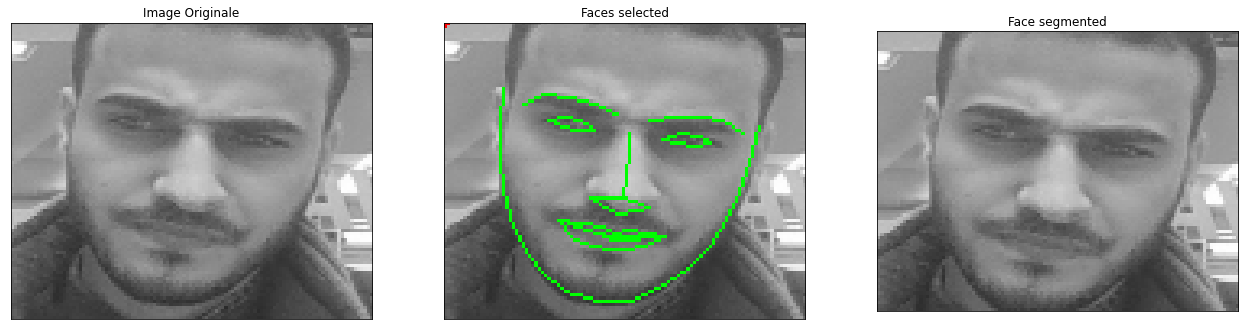

In [ ]:
img_path = home+'angry/1026.png'

img = cv2.imread(img_path)
plot_img([(pltC(img), 'Image Originale'), (pltC(draw_face_landmarks(img_path, True)), 'Faces selected'), (pltC(get_face_landmarks(img_path, True)), 'Face segmented')])

In [ ]:
def our_ft_landmark(X, Y):
    """ 
     In this function we used the points of landmark for the extraction features that we calculate distance
     between the points of the following parts: between the nose and the eyes, the eyes and the eyebrows and the mouth and the nose...
     After this calculation we do the normalization of data to manage the problems related to the difference of human faces
    """
    def get_degre(i,j):
        myradians = math.atan2(Y[i]-Y[j], X[i]-X[j])
        return math.degrees(myradians)

    f_x = [30,30,30,30,30,30,21,17,22,43,42,38,36,62,51,48,51]
    f_y = [26,54,17,48,22,21,22,21,26,47,45,40,39,66,57,54,30]
    features = []

    for i,j in zip(f_x,f_y):
        features.append(np.linalg.norm( (X[i]-X[j],Y[i]-Y[j]) ) )

    features = list(features / np.mean(features))# normalisation des données
    
    features2 = []
    features2.append((get_degre(30,26)-90))
    features2.append((get_degre(30,22)-90))
    features2.append((90-get_degre(30,17)))
    features2.append((90-get_degre(30,21)))
    features2.append((get_degre(30,54)*-1-90))
    features2.append((90-get_degre(30,48)*-1))

    features.extend(np.array(features2)/100)
    return features

In [ ]:
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor(home+"shape_predictor_68_face_landmarks.dat")


def get_landmarks(image): # from https://www.paulvangent.com/2016/08/05/emotion-recognition-using-facial-landmarks/
    """
    In this function we recover the points of landmarks and the features (our_ft_landmark)
    """
    # Ask the detector to find the bounding boxes of each face. The 1 in the
    # second argument indicates that we should upsample the image 1 time. This
    # will make everything bigger and allow us to detect more faces.
    detections = detector(image, 1)
    if len(detections) < 1: # Number of faces detected = 0
        # print("Number of faces detected: {}".format(len(detections)))
        return None
    # Draw Facial Landmarks with the predictor class
    shape = predictor(image, detections[0])
    xlist = []
    ylist = []
    for i in range(68):  # Store X and Y coordinates in two lists
        xlist.append(float(shape.part(i).x))
        ylist.append(float(shape.part(i).y))

    landmarks_vectorised = []
    landmarks_vectorised = our_ft_landmark(xlist, ylist)# Extaraction des features

    xmean = np.mean(xlist)
    ymean = np.mean(ylist)
    xcentral = [(x-xmean) for x in xlist]
    ycentral = [(y-ymean) for y in ylist]
    
    for x, y, w, z in zip(xcentral, ycentral, xlist, ylist):
        landmarks_vectorised.append(w)
        landmarks_vectorised.append(z)
#       landmarks_vectorised.append(x)
#       landmarks_vectorised.append(y)
        meannp = np.asarray((ymean, xmean))
        coornp = np.asarray((z, w))
        dist = np.linalg.norm(coornp-meannp)# Distance euclidienne
        landmarks_vectorised.append(dist)
        landmarks_vectorised.append((math.atan2(y, x)*360)/(2*math.pi))# Calcule de l'ongle entre le moyenne et un point

    return landmarks_vectorised

In [ ]:
def get_local_binary_pattern(image, numPoints, radius, eps=1e-7):
    """
   ** Feature extraction based on texture: **
     The LBP method contains information about the distribution of local micro-patterns.

     Facial expressions can be viewed as a composition of micro-patterns
     which can be effectively described by LBP features.

     An LBP histogram presents only the occurrences of micro-patterns without any indication of their location.

     @args: image (image to process)
     @return hist (LBP histogram)
    """
    lbp = feature.local_binary_pattern(
        image, numPoints, radius, method="uniform")

    (hist, _) = np.histogram(lbp.ravel(), bins=np.arange(
        0, numPoints + 3), range=(0, numPoints + 2))

    # normalize the histogram
    hist = hist.astype("float")
    hist /= (hist.sum() + eps)

    # return the histogram of Local Binary Patterns
    return hist  # , lbp

In [ ]:
def get_hog(img, visualize=False):
    # Feature extraction using Histogram of oriented gradient
    return hog(img, orientations=6, pixels_per_cell=(9, 9), cells_per_block=(1, 1), visualize = visualize)


In [ ]:
def get_hog1(img, visualize=False):
    # Feature extraction using Histogram of oriented gradient
    img =cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    return hog(img, orientations=6, pixels_per_cell=(9, 9), cells_per_block=(1, 1), visualize = visualize)


In [ ]:
faceDet = cv2.CascadeClassifier("/content/drive/MyDrive/Final_Dataset/haarcascade_frontalface_alt.xml")
faceDet2 = cv2.CascadeClassifier("/content/drive/MyDrive/Final_Dataset/haarcascade_frontalface_alt2.xml")
faceDet4 = cv2.CascadeClassifier("/content/drive/MyDrive/Final_Dataset/haarcascade_frontalface_alt_tree.xml")
faceDet3 = cv2.CascadeClassifier("/content/drive/MyDrive/Final_Dataset/haarcascade_frontalface_default.xml")
def face_extractor(img_path, flag = False):
    gray = cv2.imread(img_path,cv2.IMREAD_GRAYSCALE)
    # Face detection: it can detect aberrant data (an object is not clear can be considered like a face
    faces = faceDet.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=10, minSize=(48, 48), flags=cv2.CASCADE_SCALE_IMAGE)
    if len(faces) < 1:
        faces = faceDet2.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=10, minSize=(48, 48), flags=cv2.CASCADE_SCALE_IMAGE)
        print(2)
        if len(faces) < 1:
            print(3)
            faces = faceDet3.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=10, minSize=(48, 48), flags=cv2.CASCADE_SCALE_IMAGE)
            if len(faces) < 1:
                print(4)
                faces = faceDet4.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=10, minSize=(48, 48), flags=cv2.CASCADE_SCALE_IMAGE)
                if len(faces) < 1:
                    return None
    # We are interested in the large face that is closest in the image       
    max_surface = 0
    x, y, w,h = 0, 0, 0, 0
    for (xi, yi, wi,hi) in faces:
        if wi*hi > max_surface:
            x, y, w,h = xi, yi, wi,hi
            max_surface = wi*hi
    if(w*h!=0):
        #if h = 0 or w = 0 (nothing detected), our function returns None,
         # otherwise we determine the face well so we extract it according to the new height and width
        if flag:
            face_seg = cv2.imread(img_path)[y:y+h, x:x+w]
        else:
            face_seg = gray[y:y+h, x:x+w]
            # we normalize the height and width of the images h=96 and w=96
            face_seg = cv2.resize(face_seg, (96, 96), interpolation = cv2.INTER_AREA) # Resize face so all images have same size
        return face_seg
    
    return None

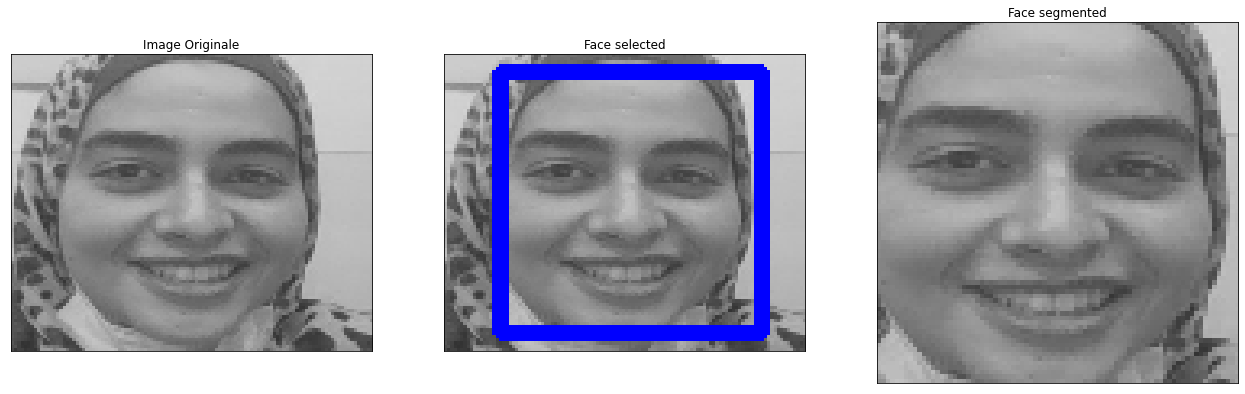

In [ ]:
img_path = '/content/drive/MyDrive/Final_Dataset/happy/100.png'
original_img = cv2.imread(img_path)
img = original_img.copy()

img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
faces = faceDet.detectMultiScale(img_gray , scaleFactor=1.1, minNeighbors=10, minSize=(5, 5), flags=cv2.CASCADE_SCALE_IMAGE)

for (x, y , w ,h) in faces:
    cv2.rectangle(img, (x,y), (x+w, y+h), (255, 0 , 0), 3)

max_surface = 0
x, y , w ,h = 0,0,0,0
for (xi, yi , wi ,hi) in faces:
    if wi*hi > max_surface:
        x, y , w ,h = xi, yi , wi ,hi
        max_surface = wi*hi
if(w*h==0):
    print('[no face detected]')
    sys.exit()
face_seg = original_img[y:y+h,x:x+w]

plot_img([(pltC(original_img), 'Image Originale'), (pltC(img), 'Face selected'), (pltC(face_seg), 'Face segmented')])

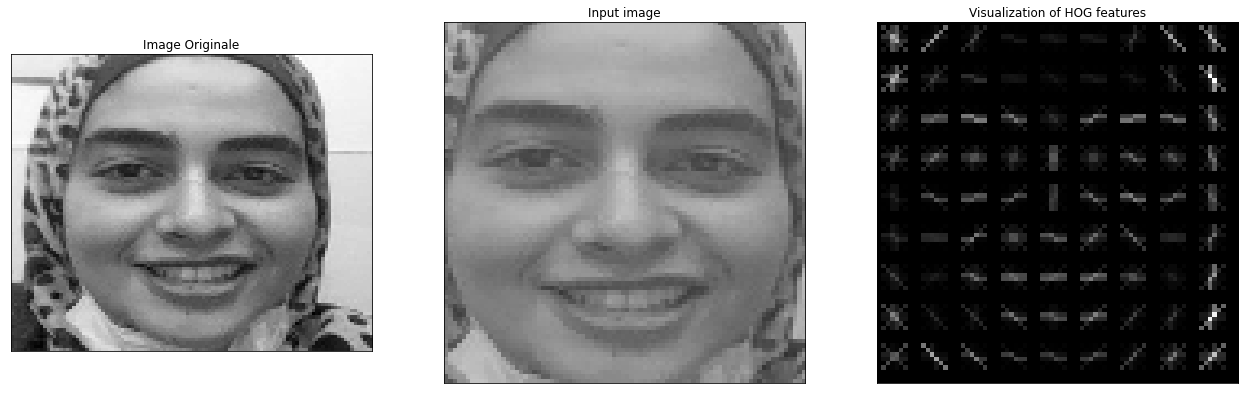

In [ ]:
img_path = '/content/drive/MyDrive/Dataset2/happy/104.png'
img = mpimg.imread(img_path)
face_seg = face_extractor(img_path, True)
hog_vec, hog_vis = get_hog1(face_seg, visualize=True)
plot_img([(img, 'Image Originale'), (pltC(face_seg), 'Input image'), (hog_vis, 'Visualization of HOG features')])

In [ ]:
def sliding_hog_windows(image):
    """
    Extraction of features using Hog with the sliding window method For each window,
    we superimpose it with each region of our image in order to detect the object that interests us.
    """
    # initialization
    image_height, image_width  = 48, 48
    window_size = 24
    window_step = 6
    hog_windows = []
    for y in range(0, image_height, window_step):
        for x in range(0, image_width, window_step):
            window = image[y:y+window_size, x:x+window_size]
            hog_windows.extend(hog(window, orientations=8, pixels_per_cell=(8, 8),
                                            cells_per_block=(1, 1)))
    return hog_windows

In [ ]:
def build_filters():
	filters = []
	ksize = 9
	#define the range for theta and nu
	for theta in np.arange(0, np.pi, np.pi / 8):
		for nu in np.arange(0, 6*np.pi/4 , np.pi / 4):
			kern = cv2.getGaborKernel((ksize, ksize), 1.0, theta, nu, 0.5, 0, ktype=cv2.CV_32F)
			kern /= 1.5*kern.sum()
			filters.append(kern)
	return filters

#---------------------------------------------------
#function to convolve the image with the filters
def process(img, filters):
	accum = np.zeros_like(img)
	for kern in filters:
		fimg = cv2.filter2D(img, cv2.CV_8UC3, kern)
		np.maximum(accum, fimg, accum)
	return accum
  
def extracting_features_gabor_filter_bank(imgg):
    #instantiating the filters
    filters = build_filters()
    f = np.asarray(filters)
    #initializing the feature vector
    feat = []
    #calculating the local energy for each convolved image
    for j in range(40):
        res = process(imgg, f[j])
        temp = 0
        for p in range(imgg.shape[0]):
            for q in range(imgg.shape[1]):
                temp = temp + res[p][q]*res[p][q]
        feat.append(temp)
    #calculating the mean amplitude for each convolved image	
    for j in range(40):
        res = process(imgg, f[j])
        temp = 0
        for p in range(imgg.shape[0]):
            for q in range(imgg.shape[1]):
                temp = temp + abs(res[p][q])
            feat.append(temp)
    #feat matrix is the feature vector for the image
    #print(feat)
    return feat

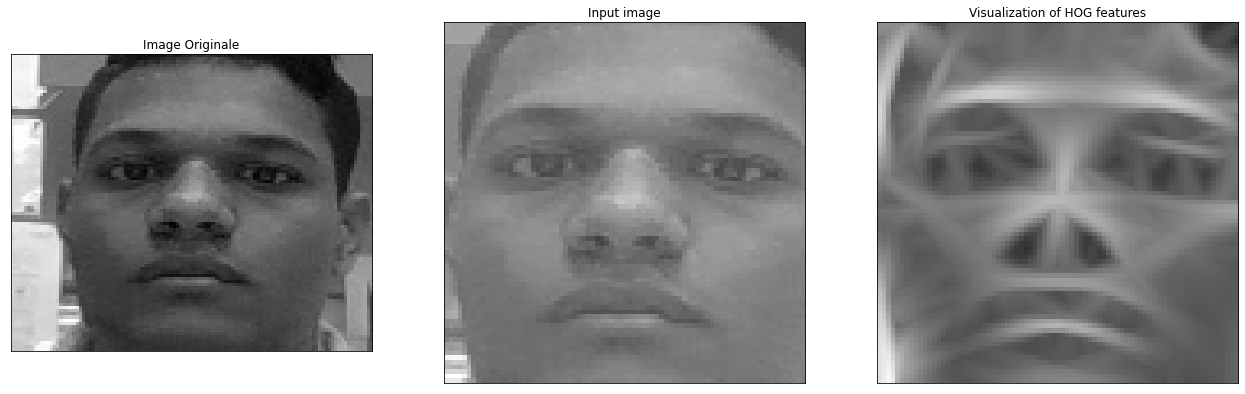

In [ ]:
def build_filters1():
    filters = []
    ksize = 31
    for theta in np.arange(0, np.pi, np.pi / 16):
        kern = cv2.getGaborKernel((ksize, ksize), 4.0, theta, 10.0, 0.5, 0, ktype=cv2.CV_32F)
        kern /= 1.5*kern.sum()
        filters.append(kern)
    return filters
 
def process1(img, filters):
    accum = np.zeros_like(img)
    for kern in filters:
        fimg = cv2.filter2D(img, cv2.CV_8UC3, kern)
        np.maximum(accum, fimg, accum)
    return accum

img_path = home+'neutral/1003.png'
img = mpimg.imread(img_path)
face_seg = face_extractor(img_path, True)

filters = build_filters1()
img_gabor = process1(face_seg , filters)
plot_img([(img, 'Image Originale'), (pltC(face_seg), 'Input image'), (pltC(img_gabor), 'Visualization of HOG features')])

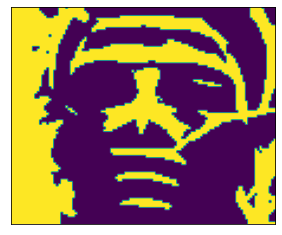

In [ ]:
img_path = home+'neutral/1003.png'
img = mpimg.imread(img_path)
img = process1(img , filters)
cv2.imwrite(home+'images/mh.png', pltC(img))
plt.imshow(img)
plt.xticks([]),plt.yticks([])
plt.show()

In [ ]:
"""
contrast limited adaptive histogram equalization: variant of Adaptive histogram equalization (AHE)
which improves the contrast of an image
"""
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))

def get_feature(img_path, face_cut=False):
    # All faces dimensions  = (96,96)
    if face_cut:
        img = face_extractor(img_path)
        

    else:
        img = cv2.imread(img_path, 0)
        img = cv2.resize(img, (96, 96), interpolation=cv2.INTER_AREA)

    if img is None:
        img = get_face_landmarks(img_path)
        if img is None:
            return None

    ft_landmarks = get_landmarks(img.copy()) # len = 295
    if ft_landmarks is None:
        return None
    
    try:
        img = cv2.resize(img, (48, 48), interpolation = cv2.INTER_AREA)#Pour reduire features de Hog
    except:
        return None

    ft_hog = get_hog(img.copy()) # len = 150
    ft_shogw = sliding_hog_windows(img.copy()) # len = 2592
    ft_gabor = extracting_features_gabor_filter_bank(img.copy()) # len= 1960
   
    global_feature = np.concatenate([ft_landmarks, ft_gabor, ft_hog, ft_shogw]).flatten() # shape = 4997
    
    return global_feature

In [ ]:
def indexing_db_sep(dir_path, face_cut, features, labels):
    folders = glob(str(dir_path)+os.path.sep+"*"+os.path.sep)
    for dir in tqdm(folders, desc='DB '+dir_path.split('/')[-1]):
        if os.path.isdir(dir):
            label = dir.split(os.path.sep)[-2]
            files = glob(str(dir)+os.path.sep+"*.*")
            for img_path in tqdm(files, desc=label+"\t", leave=False):
                feature = get_feature(img_path, face_cut)
                if feature is None:
                    continue
                features.append(feature)
                labels.append(label)

In [ ]:
def indexing_images():
    features = []
    labels = []
    indexing_db_sep("/content/drive/MyDrive/Final_Dataset", True, features, labels)       
      
    features = np.array(features)
    labels = np.array(labels)
    shape = features.shape
    print(labels.shape, features.shape)
    if not os.path.exists(home+'tools'):
        os.makedirs(home+'tools')
    np.save(home+'tools/f'+str(shape)+'.npy', features, allow_pickle=True)
    np.save(home+'tools/l'+str(shape)+'.npy', labels, allow_pickle=True)
    return shape

In [ ]:
shape = indexing_images()

DB Dataset2:   0%|          | 0/5 [00:00<?, ?it/s]

happy	:   0%|          | 0/6400 [00:00<?, ?it/s]

2


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: RuntimeWarning: overflow encountered in ubyte_scalars


2
3
4
2
3
4
2
2
2
3
4
2
3
4
2
3
2
2
3
4
2
3
4
2
3
2
3
2
3
4
2
3
2
3
4
2
3
4
2
3
2
3
4
2
3
4
2
2
3
4
2
3
4
2
3
2
3
4
2
3
4
2
2
3
4
2
3
4
2
3
2
3
4
2
3
2
3
4
2
3
2
3
4
2
2
2
3
4
2
3
4
2
3
4
2
3
4
2
3
2
2
3
4
2
3
4
2
2
3
4
2
2
3
2
3
2
3
4
2
3
2
3
2
3
4
2
3
4
2
3
4
2
3
2
3
4
2
3
4
2
3
4
2
2
3
4
2
3
4
2
3
2
3
2
3
2
3
4
2
2
3
2
3
4
2
3
4
2
3
4
2
3
4
2
3
4
2
2
3
2
3
4
2
3
4
2
3
4
2
2
3
2
3
4
2
3
4
2
2
3
4
2
3
4
2
3
2
3
4
2
3
4
2
3
4
2
3
4
2
3
4
2
3
4
2
3
4
2
2
2
3
2
3
4
2
3
4
2
3
4
2
3
4
2
2
3
2
3
4
2
3
4
2
3
4
2
3
4
2
3
4
2
3
2
2
3
4
2
2
2
3
4
2
3
4
2
3
2
2
2
3
2
3
4
2
3
2
3
4
2
3
4
2
3
4
2
3
4
2
2
3
2
3
4
2
2
2
3
2
3
4
2
2
3
4
2
3
4
2
2
3
4
2
3
4
2
3
4
2
2
2
2
2
3
4
2
3
4
2
2
2
3
4
2
3
4
2
3
4
2
3
2
3
2
2
2
3
2
3
2
2
2
2
2
3
4
2
2
3
4
2
3
4
2
3
4
2
3
2
3
2
3
4
2
3
4
2
3
4
2
2
3
4
2
3
4
2
3
2
3
4
2
3
4
2
3
4
2
3
4
2
3
4
2
3
4
2
3
4
2
2
3
4
2
3
2
3
4
2
3
2
3
2
2
3
4
2
3
4
2
3
4
2
3
2
2
3
4
2
3
2
3
4
2
3
4
2
3
2
3
2
3
4
2
3
4
2
3
4
2
2
3
2
3
2
2
3
2
3
4
2
3
4
2
3
4
2
3
2
3
4
2
3
2
2
2
3
4
2
3


sad	:   0%|          | 0/5503 [00:00<?, ?it/s]

2
3
4
2
3
4
2
3
4
2
3
4
2
3
4
2
3
4
2
3
4
2
3
4
2
3
4
2
3
4
2
3
4
2
3
4
2
3
4
2
3
4
2
3
4
2
3
4
2
3
4
2
3
4
2
3
4
2
3
4
2
3
4
2
3
4
2
3
4
2
3
4
2
3
4
2
3
4
2
3
4
2
3
4
2
3
4
2
3
4
2
3
4
2
3
4
2
3
4
2
3
4
2
3
4
2
3
4
2
3
4
2
3
4
2
3
4
2
3
4
2
3
4
2
3
4
2
3
4
2
3
4
2
3
4
2
3
4
2
3
4
2
3
4
2
3
4
2
3
4
2
3
4
2
3
4
2
3
4
2
3
4
2
3
4
2
3
4
2
3
4
2
3
4
2
3
4
2
3
4
2
3
4
2
3
4
2
3
4
2
3
4
2
3
4
2
3
4
2
3
4
2
3
4
2
3
4
2
3
4
2
3
4
2
3
4
2
3
4
2
3
4
2
3
4
2
3
4
2
3
4
2
3
4
2
3
4
2
3
4
2
3
4
2
3
4
2
3
4
2
3
4
2
3
4
2
3
4
2
3
4
2
3
4
2
3
4
2
3
4
2
3
4
2
2
2
2
2
2
2
2
2
2
2
2
2
2
3
2
2
2
3
2
2
2
3
2
3
4
2
3
2
3
2
3
2
3
4
2
3
2
3
2
3
2
3
4
2
2
2
2
2
3
2
2
2
2
2
2
2
2
2
2
2
2
2
3
2
2
2
2
2
2
3
4
2
3
4
2
3
4
2
3
4
2
3
4
2
2
2
3
4
2
3
4
2
3
2
3
4
2
3
2
2
2
2
2
3
2
2
2
2
2
3
2
2
3
2
3
2
3
2
3
2
2
3
2
3
2
2
3
2
3
2
3
2
2
2
2
2
3
2
3
2
2
3
4
2
2
2
2
2
3
4
2
3
4
2
2
3
4
2
3
4
2
2
2
3
4
2
3
2
2
2
3
2
3
4
2
3
4
2
3
4
2
3
4
2
3
4
2
3
4
2
3
4
2
3
4
2
3
4
2
3
4
2
3
4
2
3
2
3
4
2
2
3
4
2
3
2
3
2
2
2
3
4
2
3
2
3


angry	:   0%|          | 0/3327 [00:00<?, ?it/s]

2
3
4
2
3
4
2
3
4
2
3
4
2
2
3
2
3
2
3
4
2
3
4
2
3
4
2
3
4
2
3
2
2
2
2
3
2
3
4
2
3
4
2
2
3
4
2
3
4
2
3
4
2
3
4
2
3
4
2
3
4
2
3
4
2
3
4
2
3
4
2
3
2
3
4
2
3
4
2
3
4
2
3
4
2
3
2
3
4
2
3
4
2
2
3
4
2
3
4
2
3
4
2
3
4
2
3
2
2
3
4
2
3
4
2
2
3
4
2
3
4
2
3
4
2
2
3
4
2
3
2
3
4
2
2
3
4
2
3
2
3
4
2
3
4
2
3
4
2
3
4
2
3
4
2
3
4
2
2
3
4
2
3
2
3
2
3
4
2
2
3
4
2
3
4
2
3
2
3
2
3
2
3
4
2
3
4
2
2
2
3
4
2
3
4
2
3
4
2
3
2
3
4
2
3
2
3
4
2
3
4
2
3
4
2
3
4
2
2
3
2
3
4
2
3
4
2
3
2
2
3
2
3
2
3
4
2
3
4
2
2
3
4
2
3
4
2
3
2
2
3
4
2
3
4
2
3
4
2
2
3
4
2
3
4
2
3
4
2
3
2
2
3
4
2
2
3
2
3
2
3
4
2
3
4
2
3
4
2
2
2
3
2
3
4
2
3
4
2
3
4
2
3
4
2
3
4
2
3
4
2
2
3
4
2
2
3
2
3
4
2
3
4
2
3
4
2
3
4
2
2
3
4
2
3
4
2
3
2
2
2
3
4
2
2
3
2
2
3
4
2
3
4
2
3
2
2
3
4
2
3
2
3
4
2
3
4
2
3
2
3
4
2
3
4
2
3
2
3
2
3
2
2
3
4
2
3
4
2
3
2
3
4
2
3
2
2
3
4
2
3
4
2
3
2
3
2
3
4
2
3
4
2
3
4
2
3
4
2
3
4
2
3
2
3
4
2
3
4
2
3
4
2
3
4
2
3
2
3
4
2
3
2
2
3
4
2
3
2
3
2
3
2
3
4
2
2
3
4
2
2
3
4
2
3
2
3
4
2
3
4
2
3
4
2
2
3
2
3
4
2
2
3
2
3
4
2
3
4
2
3
4
2
3
4
2
3
4
2
3


surprise	:   0%|          | 0/3372 [00:00<?, ?it/s]

2
3
2
3
4
2
2
3
2
3
4
2
3
4
2
3
4
2
2
3
4
2
3
4
2
3
4
2
2
3
4
2
3
4
2
3
4
2
3
4
2
3
4
2
3
4
2
3
4
2
3
4
2
3
4
2
2
3
4
2
3
4
2
2
3
4
2
3
4
2
3
2
3
2
3
2
3
4
2
3
2
3
2
3
4
2
3
4
2
3
4
2
2
3
4
2
2
2
3
4
2
3
4
2
3
2
2
3
2
3
4
2
3
4
2
2
3
4
2
3
4
2
2
3
4
2
2
3
2
3
2
3
4
2
2
2
3
4
2
3
4
2
3
4
2
3
4
2
3
4
2
3
4
2
3
2
3
4
2
3
2
3
4
2
3
4
2
2
3
4
2
2
3
4
2
3
4
2
3
4
2
3
4
2
3
4
2
3
4
2
3
2
3
4
2
3
4
2
2
3
4
2
3
4
2
2
3
2
2
2
2
3
4
2
3
4
2
2
2
3
4
2
3
4
2
3
4
2
3
4
2
3
2
3
2
2
2
3
4
2
3
2
2
3
4
2
3
4
2
3
4
2
3
4
2
3
4
2
3
4
2
3
4
2
2
3
4
2
3
2
3
4
2
3
4
2
3
4
2
3
4
2
2
3
4
2
3
4
2
3
2
3
4
2
3
4
2
3
4
2
3
4
2
3
4
2
3
4
2
3
2
2
3
4
2
3
4
2
2
3
2
3
4
2
2
2
3
4
2
3
4
2
3
4
2
3
2
3
4
2
3
4
2
3
4
2
3
4
2
3
4
2
3
4
2
3
4
2
3
4
2
3
4
2
3
4
2
3
2
3
4
2
2
2
2
3
2
3
4
2
3
4
2
3
4
2
3
4
2
3
4
2
3
4
2
3
4
2
3
2
3
4
2
3
2
3
4
2
3
4
2
3
4
2
3
2
3
4
2
3
4
2
3
4
2
3
4
2
3
4
2
3
2
2
2
2
3
4
2
2
3
4
2
3
4
2
3
2
2
2
3
4
2
3
4
2
3
4
2
3
4
2
3
4
2
3
4
2
3
2
3
4
2
3
2
3
4
2
3
4
2
3
4
2
3
4
2
3
2
3
4
2
3
4
2
2
3
4
2
3


neutral	:   0%|          | 0/7018 [00:00<?, ?it/s]

2
3
4
2
3
4
2
3
4
2
3
4
2
3
2
2
3
2
3
4
2
2
3
4
2
3
2
3
4
2
3
2
3
4
2
3
4
2
2
3
4
2
3
2
3
4
2
3
4
2
3
2
3
4
2
2
3
4
2
3
2
3
4
2
3
4
2
2
3
4
2
3
4
2
2
2
3
2
3
4
2
2
3
4
2
2
3
4
2
2
3
4
2
3
2
3
2
3
2
2
3
4
2
3
4
2
3
4
2
3
4
2
3
4
2
3
4
2
3
4
2
3
4
2
3
2
3
4
2
3
2
3
4
2
2
2
3
4
2
3
4
2
2
2
2
3
2
3
2
3
4
2
3
4
2
3
4
2
3
2
3
2
2
2
3
2
3
4
2
3
4
2
3
4
2
3
2
3
4
2
3
4
2
3
4
2
3
4
2
3
4
2
3
4
2
2
2
3
4
2
3
4
2
2
3
4
2
2
2
2
3
4
2
2
2
3
2
3
2
2
2
2
2
2
3
4
2
2
3
2
2
3
2
3
2
2
3
2
3
2
2
3
4
2
3
2
3
2
3
4
2
3
4
2
2
2
3
4
2
3
4
2
3
4
2
2
3
2
3
4
2
2
3
2
2
3
4
2
3
4
2
3
4
2
3
2
2
2
3
4
2
2
3
4
2
3
4
2
3
4
2
2
2
3
4
2
3
4
2
3
4
2
2
3
4
2
3
2
2
3
4
2
2
2
3
4
2
3
2
3
2
3
4
2
3
4
2
3
4
2
2
3
4
2
2
2
3
4
2
2
2
3
2
3
2
2
3
4
2
2
3
4
2
2
2
3
4
2
3
4
2
3
4
2
3
2
2
3
4
2
3
4
2
3
4
2
3
4
2
3
2
3
4
2
3
2
3
4
2
2
3
4
2
3
4
2
3
4
2
2
3
4
2
3
2
3
4
2
3
2
3
2
3
2
3
4
2
3
4
2
2
2
3
4
2
3
2
3
4
2
2
3
4
2
3
4
2
3
4
2
2
3
4
2
3
2
3
4
2
3
2
3
2
2
3
4
2
3
4
2
3
4
2
3
4
2
3
4
2
3
2
3
4
2
3
4
2
3
2
3
2
3
2
2
3
4
2
3
4
2


In [ ]:
def plot_bar_emotion(y, relative=True):
    width = 0.55
    length = len(y)
    # calculate counts per type and sort, to ensure their order
    unique, counts = np.unique(y, return_counts=True)
    sorted_index = np.argsort(unique)
    unique = unique[sorted_index]
 
    if relative:
        # plot as a percentage
        counts = 100*counts[sorted_index]/len(y)
        ylabel_text = '% count'
    else:
        # plot counts
        counts = counts[sorted_index]
        ylabel_text = 'count'
    xtemp = np.arange(len(unique))
    plt.figure(figsize=(20,10))
    plt.bar(xtemp , counts, align='center', alpha=.5,width=width,  color= 'rbmgwyc')
    plt.xticks(xtemp, unique, fontsize=16)
    plt.xlabel('emontion kinds', fontsize=18)
    plt.ylabel(ylabel_text,fontsize=18)
    plt.title('DataSet emotion distribution ( images number : '+str(length)+' )' , fontsize=22)
    ax = plt.axes()
    ax.set_facecolor("black")
    plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


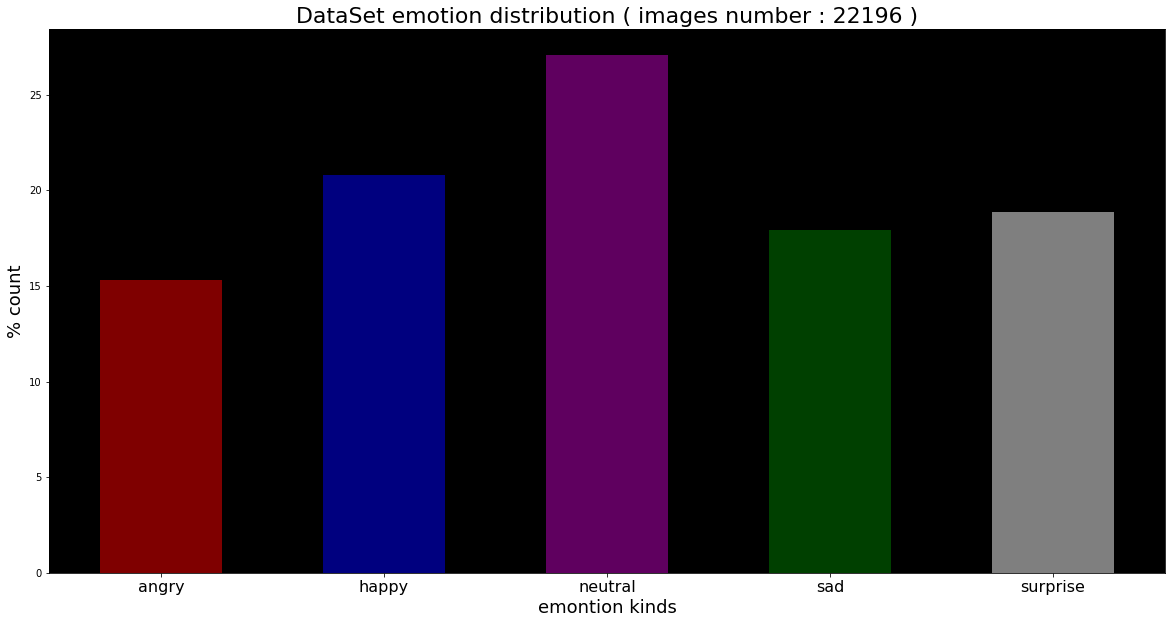

In [ ]:

shape = (22196, 4997)
features = np.load(home+'tools/f'+str(shape)+'.npy', allow_pickle=True)
labels = np.load(home+'tools/l'+str(shape)+'.npy', allow_pickle=True)


landmarks = 295
hog = 150
hog_sw = 2592
gabor = 1960
feature_landmarks = features[:, :landmarks]
feature_gabor = features[:, landmarks:landmarks+gabor]
feature_hog = features[:, landmarks+gabor:landmarks+gabor+hog]
feature_hog_sw = features[:, landmarks+gabor+hog:]

plot_bar_emotion(labels)

In [ ]:
labels

array(['happy', 'happy', 'happy', ..., 'neutral', 'neutral', 'neutral'],
      dtype='<U8')

In [ ]:
unique, frequency = np.unique(labels, 
                              return_counts = True)
# print unique values array
print("Unique Values:", 
      unique)
  
# print frequency array
print("Frequency Values:",
      frequency)


Unique Values: ['angry' 'happy' 'neutral' 'sad' 'surprise']
Frequency Values: [3403 4620 6007 3981 4185]


In [ ]:
# Assign features landmarks to X_train and labels to y_train
X_train = features
y_train = labels

In [ ]:
y_train

array(['happy', 'happy', 'happy', ..., 'neutral', 'neutral', 'neutral'],
      dtype='<U8')

In [ ]:
X_train

array([[2.2793277 , 1.57570914, 1.6213524 , ..., 0.25600989, 0.        ,
        0.2889457 ],
       [2.3918843 , 1.39908314, 1.86951132, ..., 0.08465567, 0.39501731,
        0.33220349],
       [1.86650275, 0.66597055, 2.32726894, ..., 0.024833  , 0.07775838,
        0.46115855],
       ...,
       [2.12685446, 1.39133935, 1.7627243 , ..., 0.32261983, 0.16367486,
        0.04875713],
       [2.05734675, 1.28732941, 1.79521838, ..., 0.09345549, 0.28562202,
        0.4181152 ],
       [2.08273438, 1.31723688, 1.80553901, ..., 0.38132604, 0.25641581,
        0.38132604]])

In [ ]:
# Upload test images landmarks
shape = (629, 4997)
X_test = np.load(home+'tools/f'+str(shape)+'.npy', allow_pickle=True)
y_test = np.load(home+'tools/l'+str(shape)+'.npy', allow_pickle=True)

#Model Training


In [ ]:
from xgboost import XGBClassifier
from sklearn import metrics

model = XGBClassifier(verbosity=2,seed=0, n_estimators=150,gamma= 0.24, max_depth=4, learning_rate=0.1,reg_lambda=50.0, scale_pos_weight=1)
model.fit(X_train, y_train)
preds = model.predict(X_test)
metrics.accuracy_score(y_test, preds)

[08:55:54] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[08:56:03] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[08:56:11] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[08:56:26] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[08:56:40] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[08:56:49] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[08:56:57] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[08:57:06] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nod

0.863275039745628

In [ ]:
#saving the model
import pickle
file_name = "xgb_model.pkl"

# save
pickle.dump(model, open(file_name, "wb"))

# load
xgb_model = pickle.load(open(file_name, "rb"))
 


In [ ]:
img_path= '/content/photo1.jpg'
img = cv2.imread(img_path)

